In [1]:
import mbuild
import foyer
import mosdef_cassandra as mc
import unyt as u
from mosdef_cassandra.analysis import ThermoProps
from mosdef_cassandra.utils.tempdir import temporary_cd
from mosdef_cassandra.utils.get_files import get_example_ff_path, get_example_mol2_path

import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress


## Formic Acid

In [6]:
atoms = mbuild.load("O=CO", smiles=True)
ff = foyer.forcefields.load_OPLSAA()
atoms_ff = ff.apply(atoms)

box = mbuild.Box(lengths=[3.0, 3.0, 3.0])
# Create box and species list
box_list = [box]
species_list = [atoms_ff]

mols_to_add = [[64]]

system = mc.System(box_list, species_list, mols_to_add=mols_to_add)
moveset = mc.MoveSet("gcmc", species_list)


temperature = 450.0 * u.K

custom_args = {
    "prop_freq" : 10,
    "max_molecules": [5000]
}


mus_adsorbate = np.arange(-120, -100, 4) * u.kJ/u.mol

for mu_adsorbate in mus_adsorbate:
    dirname = f'formic_acid/pure_mu_{mu_adsorbate:.1f}'.replace(" ", "_").replace("/", "-")
    if not os.path.isdir(dirname):
        os.mkdir(dirname)
    else:
        pass
    
    with temporary_cd(dirname):
        species_list = [atoms_ff]
        
        if mu_adsorbate < -34:
            boxl = 10. # nm
        else:
            boxl = 5. # nm
            
        box_list = [mbuild.Box([boxl,boxl,boxl])]
        system = mc.System(box_list, species_list)
        moveset = mc.MoveSet('gcmc', species_list)

        mc.run(
            system=system,
            moveset=moveset,
            run_type="equil",
            run_length=100000,
            temperature=temperature,
            chemical_potentials = [mu_adsorbate],
            **custom_args
        )

/home/woodrowwilson/Programs/miniconda3/lib/python3.9/site-packages/foyer/forcefield.py:348: UserWarning: Parameters have not been assigned to all impropers. Total system impropers: 1, Parameterized impropers: 0. Note that if your system contains torsions of Ryckaert-Bellemans functional form, all of these torsions are processed as propers
  warnings.warn(msg)
/home/woodrowwilson/Programs/miniconda3/lib/python3.9/site-packages/mbuild/formats/cassandramcf.py:134: UserWarning: Unable to infer LJ 1-4 scaling factor. Setting to 0.0
  warnings.warn(


Using the following executables for Cassandra:
Python: /home/woodrowwilson/Programs/miniconda3/bin/python
library_setup: /home/woodrowwilson/Programs/cassandra/1.2.6/Exe/library_setup.py
Cassandra: /home/woodrowwilson/Programs/cassandra/1.2.6/Exe/cassandra.exe
Generating fragment libraries...
Running Cassandra...
Using the following executables for Cassandra:
Python: /home/woodrowwilson/Programs/miniconda3/bin/python
library_setup: /home/woodrowwilson/Programs/cassandra/1.2.6/Exe/library_setup.py
Cassandra: /home/woodrowwilson/Programs/cassandra/1.2.6/Exe/cassandra.exe
Generating fragment libraries...
Running Cassandra...
Using the following executables for Cassandra:
Python: /home/woodrowwilson/Programs/miniconda3/bin/python
library_setup: /home/woodrowwilson/Programs/cassandra/1.2.6/Exe/library_setup.py
Cassandra: /home/woodrowwilson/Programs/cassandra/1.2.6/Exe/cassandra.exe
Generating fragment libraries...
Running Cassandra...
Using the following executables for Cassandra:
Python: 

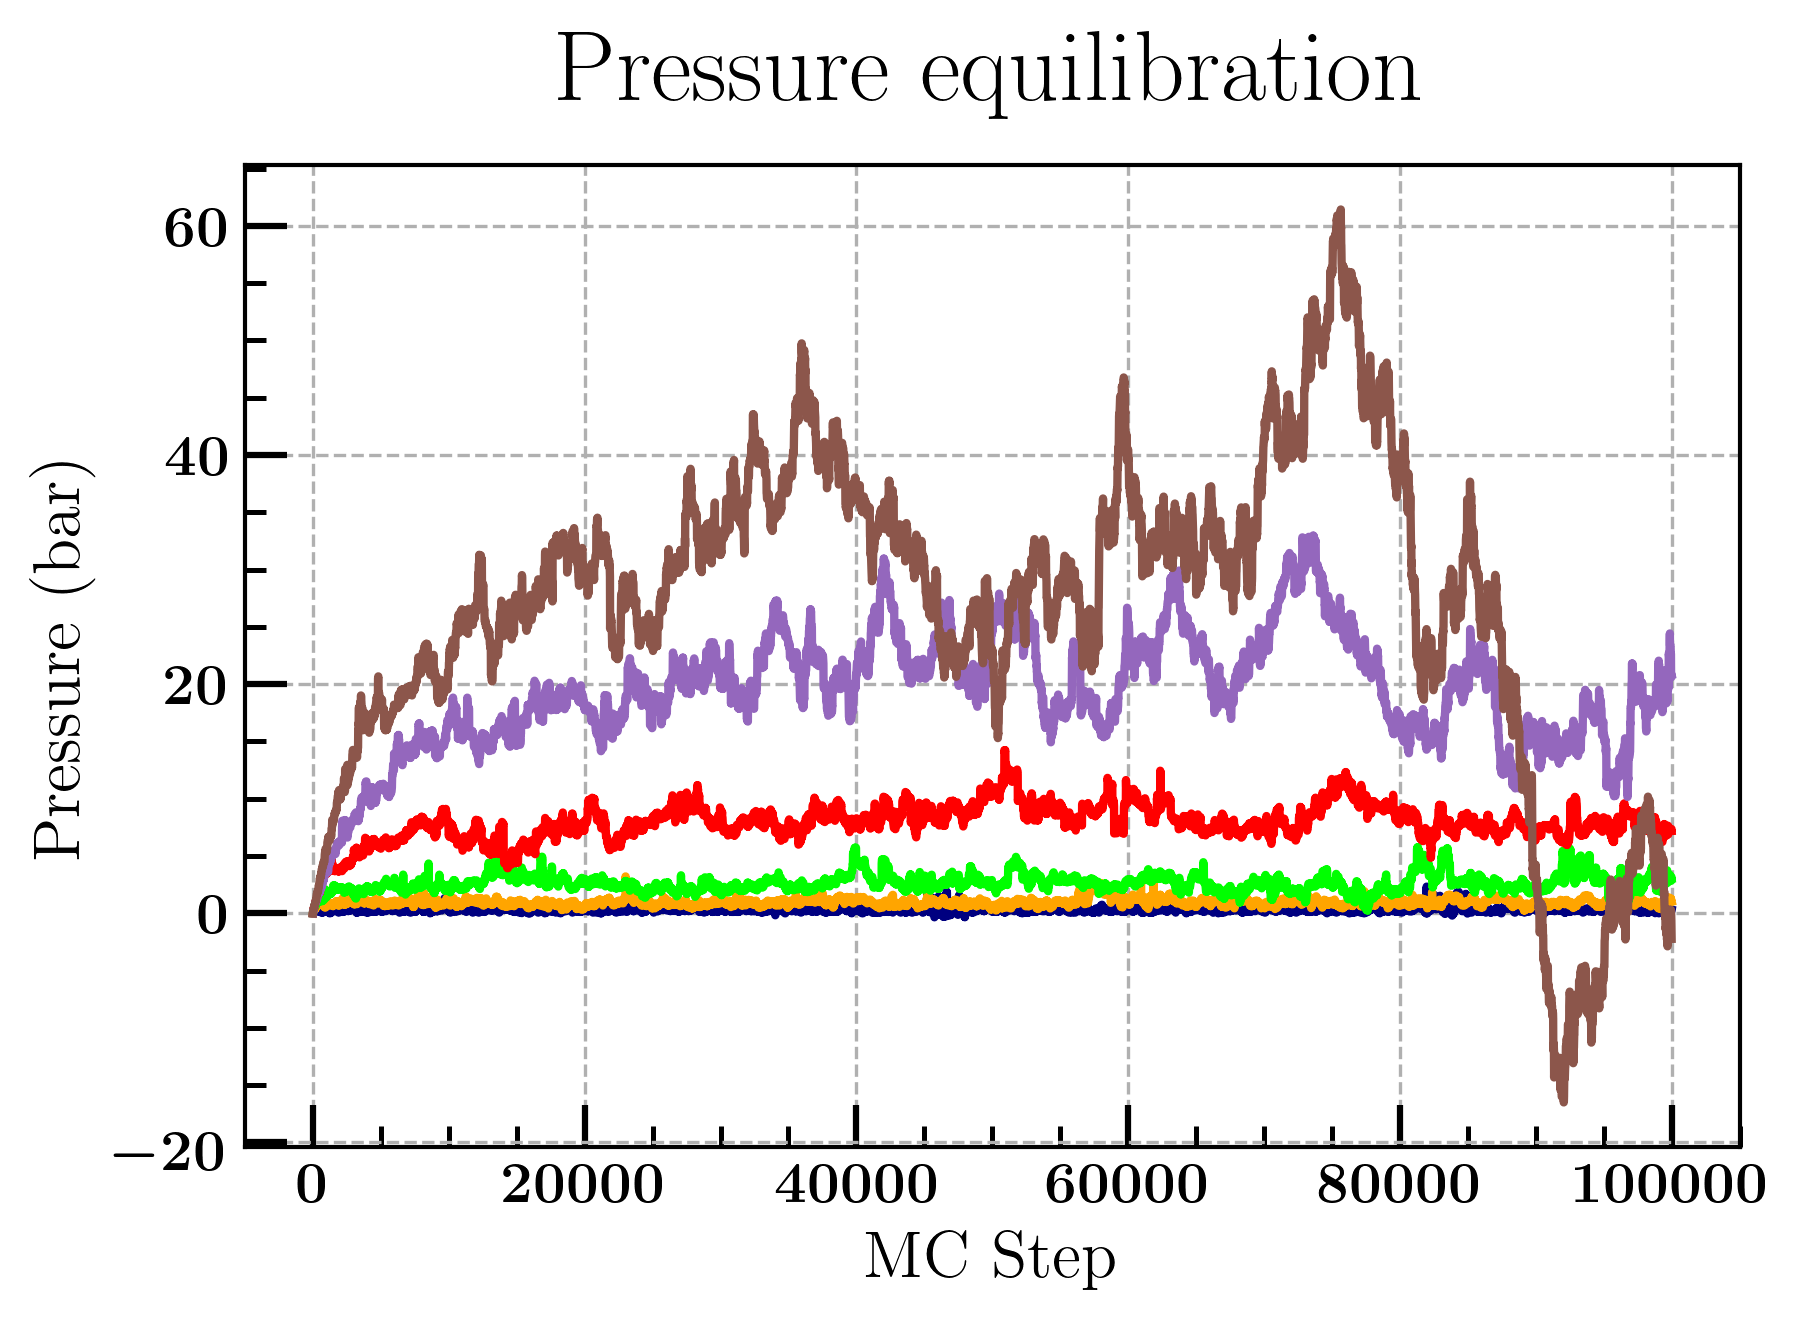

In [7]:
pressures = []
for mu_adsorbate in mus_adsorbate:
    dirname = f'formic_acid/pure_mu_{mu_adsorbate:.1f}'.replace(" ", "_").replace("/", "-")
    thermo = ThermoProps(dirname + "/gcmc.out.prp")
    pressures.append(np.mean(thermo.prop("Pressure", start=30000)))
    plt.plot(thermo.prop("MC_STEP"), thermo.prop("Pressure"))
plt.title("Pressure equilibration")
plt.xlabel("MC Step")
plt.ylabel("Pressure (bar)")
pass


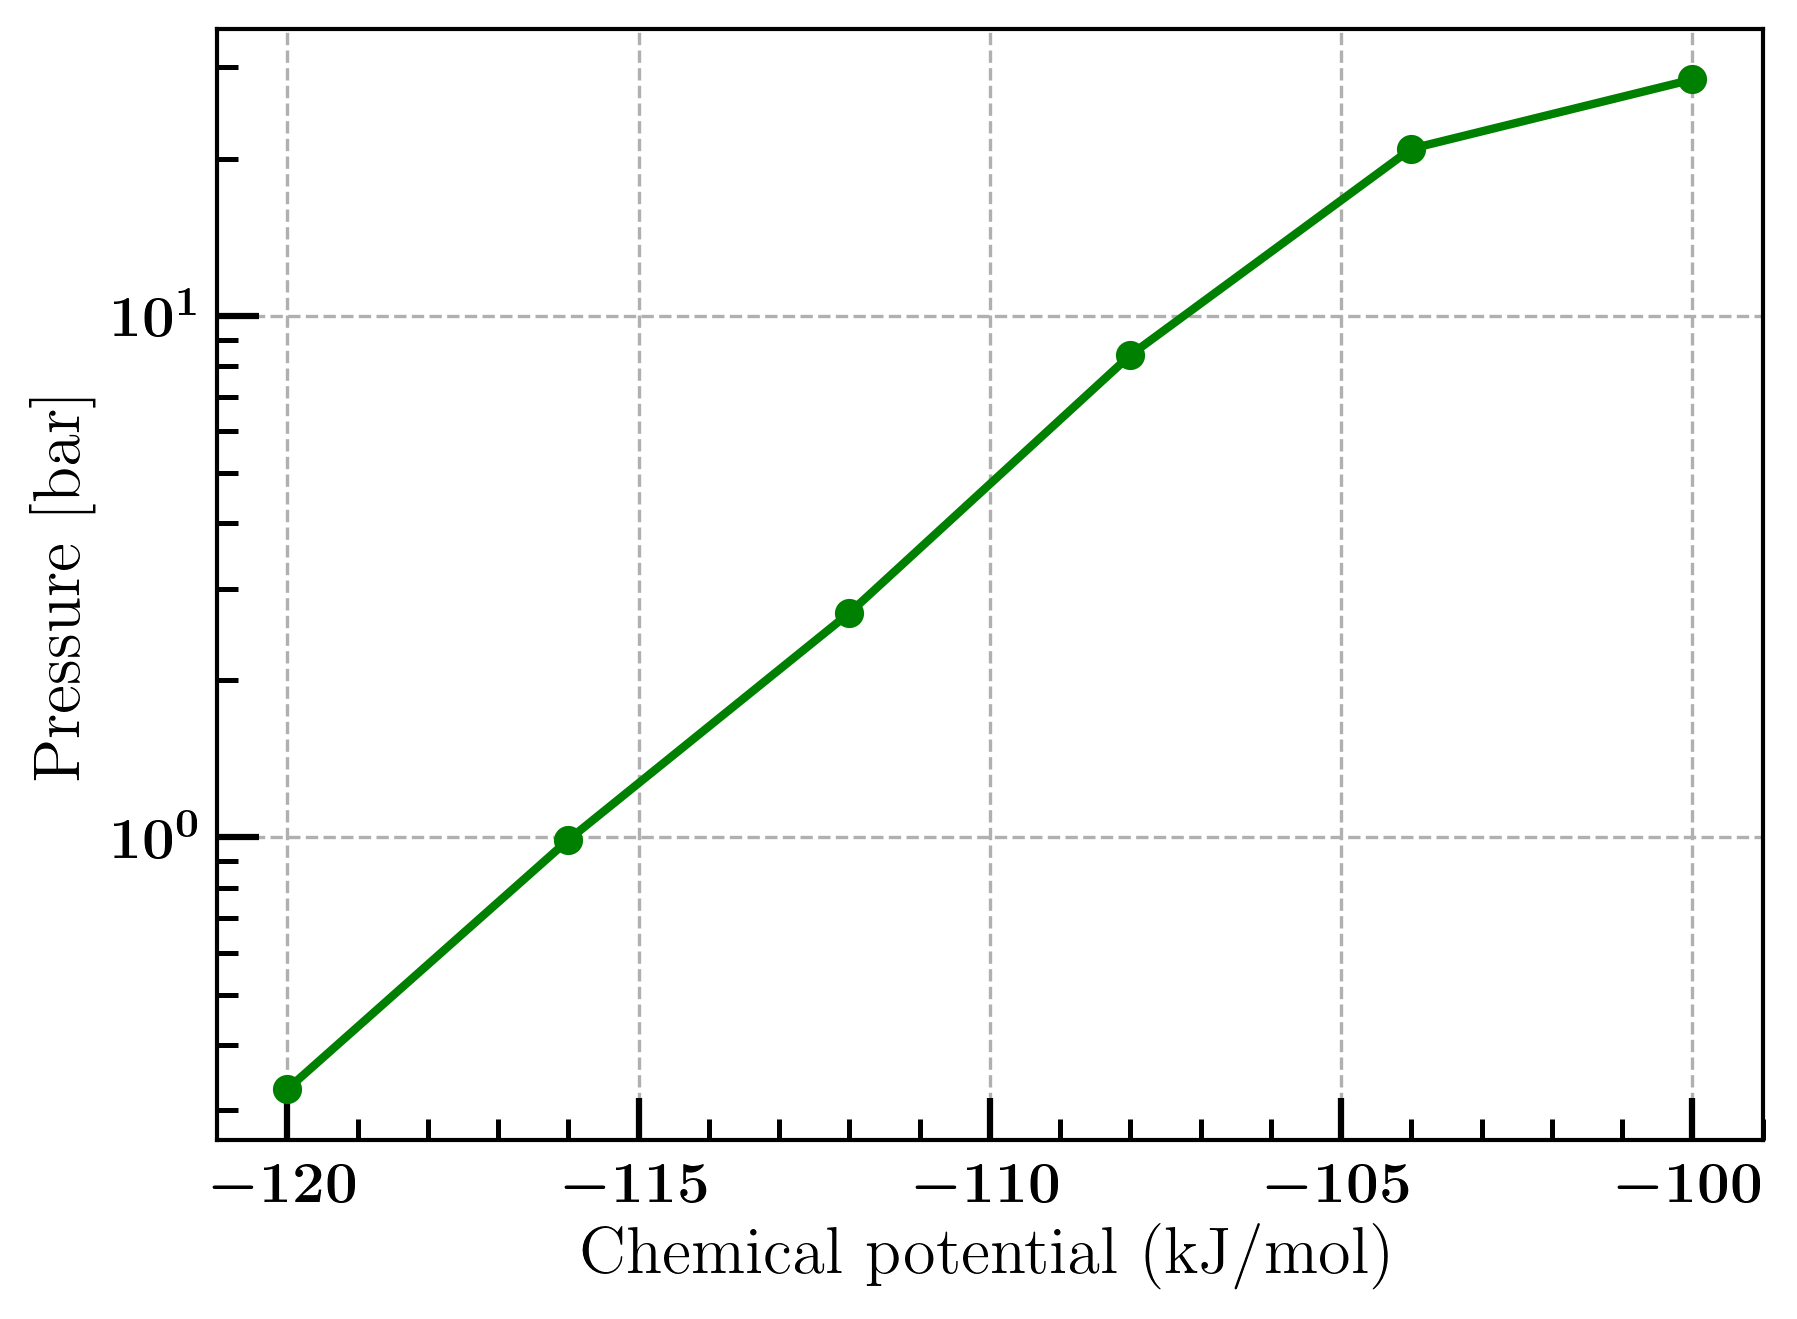

In [8]:
plt.plot(mus_adsorbate, pressures, 'go-')
plt.xlabel("Chemical potential (kJ/mol)")
plt.ylabel("Pressure [bar]")
plt.yscale('log')
pass

In [9]:
slope, intercept, r_value, p_value, stderr = linregress(np.log(pressures).flatten(),y=mus_adsorbate.flatten())


pressures = [
    50.0
] * u.bar

mus = (slope * np.log(pressures.in_units(u.bar)) + intercept) * u.kJ/u.mol
for (mu, pressure) in zip(mus, pressures):
    print(f"We will run at mu = {mu:0.2f} to simulate {pressure:0.0f}")



We will run at mu = -99.41 kJ/mol to simulate 50 bar


## Water

In [4]:
# Load water with SPC/E geometry from mol2 file
molecule = mbuild.load(get_example_mol2_path("spce"))

# Create an empty mbuild.Box
box = mbuild.Box(lengths=[3.0, 3.0, 3.0])

# Load force field
spce = foyer.Forcefield(get_example_ff_path("spce"))

# Use foyer to apply force field
atoms_ff = spce.apply(molecule)

# Create box and species list
box_list = [box]
species_list = [atoms_ff]

# Use Cassandra to insert some initial number of species
mols_to_add = [[50]]

# Define the System
system = mc.System(box_list, species_list, mols_to_add=mols_to_add)
# Define the MoveSet
moveset = mc.MoveSet("gcmc", species_list)

# Note here we need to use the angle_style="fixed" keyword argument
# SPC/E geometry is rigid; default angle style is "harmonic"
custom_args = {"angle_style": ["fixed"],
               "prop_freq" : 10,
               "max_molecules": [5000],
              "temperature": 450 * u.K}

mus_adsorbate = np.arange(-50, -26, 4) * u.kJ/u.mol

for mu_adsorbate in mus_adsorbate:
    dirname = f'pure_mu_{mu_adsorbate:.1f}'.replace(" ", "_").replace("/", "-")
    if not os.path.isdir(dirname):
        os.mkdir(dirname)
    else:
        pass
    
    with temporary_cd(dirname):
        species_list = [atoms_ff]
        
        if mu_adsorbate < -34:
            boxl = 3. # nm
        else:
            boxl = 1.5 # nm
            
        box_list = [mbuild.Box([boxl,boxl,boxl])]
        system = mc.System(box_list, species_list)
        moveset = mc.MoveSet('gcmc', species_list)

        mc.run(
            system=system,
            moveset=moveset,
            run_type="equil",
            run_length=100000,
            chemical_potentials = [mu_adsorbate],
            **custom_args
        )

/home/woodrowwilson/Programs/miniconda3/lib/python3.9/site-packages/mdtraj/core/trajectory.py:438: UserWarning: top= kwargs ignored since this file parser does not support it
  warnings.warn('top= kwargs ignored since this file parser does not support it')
/home/woodrowwilson/Programs/miniconda3/lib/python3.9/site-packages/foyer/forcefield.py:620: UserWarning: No force field version number found in force field XML file.
  warnings.warn(
/home/woodrowwilson/Programs/miniconda3/lib/python3.9/site-packages/foyer/forcefield.py:632: UserWarning: No force field name found in force field XML file.
  warnings.warn(
/home/woodrowwilson/Programs/miniconda3/lib/python3.9/site-packages/foyer/forcefield.py:644: UserWarning: No combining rule found in force field XML file.
  warnings.warn(


Using the following executables for Cassandra:
Python: /home/woodrowwilson/Programs/miniconda3/bin/python
library_setup: /home/woodrowwilson/Programs/cassandra/1.2.6/Exe/library_setup.py
Cassandra: /home/woodrowwilson/Programs/cassandra/1.2.6/Exe/cassandra.exe
Generating fragment libraries...
Running Cassandra...


KeyboardInterrupt: 

## Methanol

In [5]:
molecule = mbuild.load("CO", smiles=True)
molecule.energy_minimize(forcefield="GAFF")


# Load force field
ff = foyer.forcefields.load_OPLSAA()

# Use foyer to apply force field
atoms_ff = ff.apply(molecule)
species_list = [atoms_ff]

custom_args = {"prop_freq" : 10,
               "max_molecules": [5000],
              "temperature": 450 * u.K}

mus_adsorbate = np.arange(-50, -26, 4) * u.kJ/u.mol

for mu_adsorbate in mus_adsorbate:
    dirname = f'methanol/pure_mu_{mu_adsorbate:.1f}'.replace(" ", "_").replace("/", "-")
    if not os.path.isdir(dirname):
        os.mkdir(dirname)
    else:
        pass
    
    with temporary_cd(dirname):
        species_list = [atoms_ff]
        
        if mu_adsorbate < -34:
            boxl = 3. # nm
        else:
            boxl = 2.1 # nm
            
            
       # Create an empty mbuild.Box
        box = mbuild.Box(lengths=[boxl,  boxl,  boxl])
        
        # Create box and species list
        box_list = [box]
        species_list = [atoms_ff]
        
        # Use Cassandra to insert some initial number of species
        mols_to_add = [[50]]

        # Define the System
        system = mc.System(box_list, species_list, mols_to_add=mols_to_add)
        # Define the MoveSet
        moveset = mc.MoveSet("gcmc", species_list)
        
        custom_args = {"prop_freq" : 10,
               "max_molecules": [5000],
              "temperature": 450 * u.K}

        mc.run(
            system=system,
            moveset=moveset,
            run_type="equil",
            run_length=100000,
            chemical_potentials = [mu_adsorbate],
            **custom_args
        )

/home/woodrowwilson/Programs/miniconda3/lib/python3.9/site-packages/mbuild/compound.py:1910: UserWarning: Performing energy minimization using the Open Babel package. Please refer to the documentation to find the appropriate citations for Open Babel and the GAFF force field
  warn(
*** Open Babel Warning  in Translate
  Cannot perform atom type translation: table cannot find requested types.
*** Open Babel Warning  in ReadMolecule
  This Mol2 file is non-standard. Problem with molecule: RES Cannot interpret atom types correctly, instead attempting to interpret atom type: O as elements instead.
*** Open Babel Warning  in Translate
  Cannot perform atom type translation: table cannot find requested types.
/home/woodrowwilson/Programs/miniconda3/lib/python3.9/site-packages/foyer/forcefield.py:348: UserWarning: Parameters have not been assigned to all impropers. Total system impropers: 4, Parameterized impropers: 0. Note that if your system contains torsions of Ryckaert-Bellemans functiona

Using the following executables for Cassandra:
Python: /home/woodrowwilson/Programs/miniconda3/bin/python
library_setup: /home/woodrowwilson/Programs/cassandra/1.2.6/Exe/library_setup.py
Cassandra: /home/woodrowwilson/Programs/cassandra/1.2.6/Exe/cassandra.exe
Generating fragment libraries...
Running Cassandra...
Using the following executables for Cassandra:
Python: /home/woodrowwilson/Programs/miniconda3/bin/python
library_setup: /home/woodrowwilson/Programs/cassandra/1.2.6/Exe/library_setup.py
Cassandra: /home/woodrowwilson/Programs/cassandra/1.2.6/Exe/cassandra.exe
Generating fragment libraries...
Running Cassandra...
Using the following executables for Cassandra:
Python: /home/woodrowwilson/Programs/miniconda3/bin/python
library_setup: /home/woodrowwilson/Programs/cassandra/1.2.6/Exe/library_setup.py
Cassandra: /home/woodrowwilson/Programs/cassandra/1.2.6/Exe/cassandra.exe
Generating fragment libraries...
Running Cassandra...
Using the following executables for Cassandra:
Python: 

CassandraRuntimeError: Cassandra exited with an error, see mosdef_cassandra_2022-09-20_09:40:40.328287.log for details.

## Tetralin

In [13]:
# Load water with SPC/E geometry from mol2 file
molecule = mbuild.load("c1ccc2c(c1)CCCC2", smiles=True)
molecule.energy_minimize(forcefield="GAFF")

# Load force field
ff = foyer.forcefields.load_OPLSAA()

# Use foyer to apply force field
atoms_ff = ff.apply(molecule)

mus_adsorbate = np.arange(-70, -69, 0.1) * u.kJ/u.mol

for mu_adsorbate in mus_adsorbate:
    dirname = f'tetralin/pure_mu_{mu_adsorbate:.1f}'.replace(" ", "_").replace("/", "-")
    if not os.path.isdir(dirname):
        os.mkdir(dirname)
    else:
        pass
    
    with temporary_cd(dirname):
        
        if mu_adsorbate < -34:
            boxl = 3. # nm
        else:
            boxl = 2.1 # nm
            
        # Create an empty mbuild.Box
        box = mbuild.Box(lengths=[boxl, boxl, boxl])
        
        # Create box and species list
        box_list = [box]
        species_list = [atoms_ff]
        
        # Use Cassandra to insert some initial number of species
        mols_to_add = [[50]]

        # Define the System
        system = mc.System(box_list, species_list, mols_to_add=mols_to_add)
        # Define the MoveSet
        moveset = mc.MoveSet("gcmc", species_list)
        
        custom_args = {"prop_freq" : 10,
               "max_molecules": [5000],
              "temperature": 450 * u.K}
        
        mc.run(
            system=system,
            moveset=moveset,
            run_type="equil",
            run_length=100000,
            chemical_potentials = [mu_adsorbate],
            **custom_args
        )


/home/woodrowwilson/Programs/miniconda3/lib/python3.9/site-packages/mbuild/compound.py:1910: UserWarning: Performing energy minimization using the Open Babel package. Please refer to the documentation to find the appropriate citations for Open Babel and the GAFF force field
  warn(
/home/woodrowwilson/Programs/miniconda3/lib/python3.9/site-packages/foyer/forcefield.py:348: UserWarning: Parameters have not been assigned to all impropers. Total system impropers: 22, Parameterized impropers: 0. Note that if your system contains torsions of Ryckaert-Bellemans functional form, all of these torsions are processed as propers
  warnings.warn(msg)


Using the following executables for Cassandra:
Python: /home/woodrowwilson/Programs/miniconda3/bin/python
library_setup: /home/woodrowwilson/Programs/cassandra/1.2.6/Exe/library_setup.py
Cassandra: /home/woodrowwilson/Programs/cassandra/1.2.6/Exe/cassandra.exe
Generating fragment libraries...
Running Cassandra...
Using the following executables for Cassandra:
Python: /home/woodrowwilson/Programs/miniconda3/bin/python
library_setup: /home/woodrowwilson/Programs/cassandra/1.2.6/Exe/library_setup.py
Cassandra: /home/woodrowwilson/Programs/cassandra/1.2.6/Exe/cassandra.exe
Generating fragment libraries...
Running Cassandra...
Using the following executables for Cassandra:
Python: /home/woodrowwilson/Programs/miniconda3/bin/python
library_setup: /home/woodrowwilson/Programs/cassandra/1.2.6/Exe/library_setup.py
Cassandra: /home/woodrowwilson/Programs/cassandra/1.2.6/Exe/cassandra.exe
Generating fragment libraries...
Running Cassandra...
Using the following executables for Cassandra:
Python: 

KeyboardInterrupt: 